In [62]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import pymc3 as pm
import scipy
from tqdm import tqdm

In [14]:
df = pd.read_csv("data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done
49739,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14
49740,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14
49741,goldfish@active.fi,active.fi,ThresholdCondition,1000,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14
49742,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14
49743,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,179,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14
147618,azalea@active.fi,active.fi,ThresholdCondition,1071,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14
147619,azalea@active.fi,active.fi,ThresholdCondition,1196,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14
147620,azalea@active.fi,active.fi,ThresholdCondition,1282,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14


In [22]:
df["user_cd"] = df.user.values + df.condition.values
uniq_user_cd = df.user_cd.unique()

In [23]:
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 

In [24]:
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values

In [73]:
def objective(
        param,
        hist,
        success,
        timestamp,
        eps=np.finfo(np.float).eps):
    
    a, b = param

    log_p_hist = np.zeros(len(hist))

    # For each item
    for item in np.unique(hist):

        is_item = hist == item
        rep = timestamp[is_item]
        n = len(rep)

        log_p_item = np.zeros(n)
        # first presentation is success for sure
        
        delta_rep = rep[1:] - rep[:n-1]
        assert np.all(delta_rep > 1)
        n_pres = np.arange(1, n)
        
        fr = a * (1 - b) ** (n_pres - 1)
        log_p_item[1:] = -fr * delta_rep

        log_p_hist[is_item] = log_p_item
    
    p_hist = np.exp(log_p_hist)
    failure = np.invert(success)
    p_hist[failure] = 1 - p_hist[failure]
    _log_lik = np.log(p_hist + eps)
    sum_ll = _log_lik.sum()
    return - sum_ll


def optimize(user_df):
    
    hist = user_df["item"].values
    success = user_df["success"].values.astype(bool)
    timestamp = user_df["timestamp"].values
    
    # Define bounds and an initial guess
    n_param = 2
    bounds = [(2e-07, 0.025), (0, 1)]
    init_guess = ((0.01, 0.5))

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=bounds,
        args=(hist, success, timestamp))
    return res

In [74]:
r = []

for user, user_df in tqdm(df.groupby("user")):
    res = optimize(user_df)
    r.append({"user": user, "alpha": res.x[0], "beta": res.x[1]})

df_fit = pd.DataFrame(r)
df_fit

100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


,user,alpha,beta
0,ageratum@active.fi,0.000006,0.232539
1,alchemilla@active.fi,0.000004,0.042187
2,amaranthus@active.fi,0.000004,0.069016
3,amaryllis@active.fi,0.000029,0.133179
4,anemone@active.fi,0.000011,0.042215
5,armadillo@active.fi,0.000006,0.329165
6,azalea@active.fi,0.000012,0.000000
7,barracuda@active.fi,0.000011,0.067958
8,bear@active.fi,0.000006,0.131825
9,bee@active.fi,0.000010,0.033753


(0.0, 1.0)

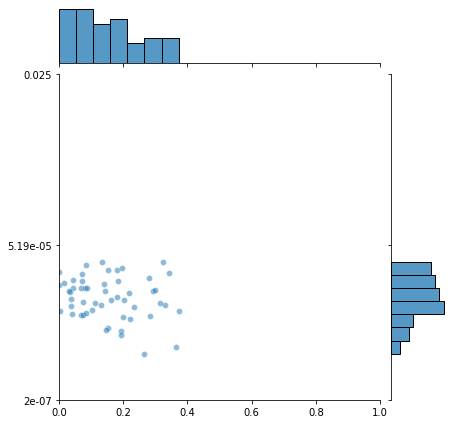

In [75]:
g = sns.jointplot(x=df_fit.beta.values, y=np.log(df_fit.alpha.values),
                  joint_kws = dict(alpha=0.5,))
ax = g.ax_joint
ax.set_ylim((np.log(2e-07), np.log(0.025)))
ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"))

ax.set_xlim((0, 1))

In [87]:
def objective(
        param,
        success,
        timestamp,
        eps=np.finfo(np.float).eps):
    
    a, b = param

    rep = timestamp
    n = len(rep)

    log_p_item = np.zeros(n)
    # first presentation is success for sure

    delta_rep = rep[1:] - rep[:n-1]
    n_pres = np.arange(1, n)

    fr = a * (1 - b) ** (n_pres - 1)
    log_p_item[1:] = -fr * delta_rep
    
    p_ = np.exp(log_p_item)
    failure = np.invert(success)
    p_[failure] = 1 - p_[failure]
    _log_lik = np.log(p_ + eps)
    sum_ll = _log_lik.sum()
    return - sum_ll


def optimize(item_df):
    
    item_df.sort_values(by="timestamp")

    success = item_df["success"].values.astype(bool)
    timestamp = item_df["timestamp"].values
    
    # Define bounds and an initial guess
    n_param = 2
    bounds = [(2e-07, 0.025), (0, 1)]
    init_guess = ((0.01, 0.5))

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=bounds,
        args=((success, timestamp)))
    return res

In [88]:
r = []

for user, user_df in tqdm(df.groupby("user")):  
    for item, item_df in df.groupby("item"):
        
        res = optimize(item_df)
        r.append({"user": user, "item": item, "alpha": res.x[0], "beta": res.x[1]})

df_fit_item = pd.DataFrame(r)
df_fit_item

  0%|          | 0/53 [00:00<?, ?it/s]<ipython-input-87-9cdbc5e471a3>:21: RuntimeWarning: overflow encountered in exp
  p_ = np.exp(log_p_item)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 53/53 [07:04<00:00,  8.00s/it]


,user,item,alpha,beta
0,ageratum@active.fi,1,0.010000,0.500000
1,ageratum@active.fi,2,0.010000,0.500000
2,ageratum@active.fi,3,0.010000,0.500000
3,ageratum@active.fi,4,0.010000,0.500000
4,ageratum@active.fi,5,0.000591,0.637700
...,...,...,...,...
105889,vulture@active.fi,2051,0.000006,0.000000
105890,vulture@active.fi,2052,0.010000,0.500000
105891,vulture@active.fi,2053,0.010000,0.500000
105892,vulture@active.fi,2054,0.010000,0.500000


In [ ]:
with pm.Model() as model:

    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    M = pm.gp.mean.Linear(coeffs=0)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=x_sorted.reshape(-1, 1))
    
    ρ2 = pm.HalfCauchy('ρ2', 5)
    η2 = pm.HalfCauchy('η2', 5)
    M2 = pm.gp.mean.Linear(coeffs=0)
    K2 = (η2**2) * pm.gp.cov.ExpQuad(1, ρ2) 
    gp2 = pm.gp.Latent(mean_func=M2, cov_func=K2)
    g = gp2.prior("g", X=p_sorted.reshape(-1, 1))
    
    est_eu =  g * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)